# Step 1: Load Required Libraries
We start by importing the necessary libraries for data handling, visualization, and machine learning.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For model preparation later
from sklearn.model_selection import train_test_split

# Step 2: Load Train, Test, and Evaluation Datasets
We have three separate datasets: one for training, one for testing, and one for final evaluation.

In [24]:
# Reload the datasets to restore Fraud_Ind
train_df = pd.read_csv("dataset1.csv")
test_df = pd.read_csv("dataset2.csv")

# Convert Fraud_Ind safely
for df in [train_df, test_df]:
    if df['Fraud_Ind'].dtype == 'object':
        df['Fraud_Ind'] = df['Fraud_Ind'].map({'Y': 1, 'N': 0})

# Step 3: Initial Data Inspection
Before preprocessing, let's check:
- Column names and data types
- Missing values
- Target column distribution (Fraud_Ind)

In [27]:
# Check column info
train_df.info()

# Check for missing values
print("\nMissing values in training set:")
print(train_df.isnull().sum())

# Target column distribution
print("\nTarget column distribution (Fraud_Ind):")
print(train_df['Fraud_Ind'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 70 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Claim_ID                             40000 non-null  object 
 1   Bind_Date1                           40000 non-null  object 
 2   Customer_Life_Value1                 40000 non-null  int64  
 3   Age_Insured                          40000 non-null  int64  
 4   Policy_Num                           40000 non-null  int64  
 5   Policy_State                         40000 non-null  object 
 6   Policy_Start_Date                    40000 non-null  object 
 7   Policy_Expiry_Date                   40000 non-null  object 
 8   Policy_BI                            40000 non-null  float64
 9   Policy_Ded                           40000 non-null  int64  
 10  Policy_Premium                       40000 non-null  float64
 11  Umbrella_Limit              

In [29]:
# Clean training and test data
for df in [train_df, test_df]:
    # 1. Fill numeric columns with median
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('Fraud_Ind')
    df[numeric_cols] = df[numeric_cols].apply(lambda col: col.fillna(col.median()))
    
    # 2. Fill categorical columns with mode
    categorical_cols = df.select_dtypes(include=['object']).columns
    df[categorical_cols] = df[categorical_cols].apply(lambda col: col.fillna(col.mode()[0]))


In [30]:
print(train_df.isna().sum().sum())
print(test_df.isna().sum().sum())

0
0


# Step 4: Data Cleaning
- Convert `Fraud_Ind` to numeric (Y → 1, N → 0).
- Drop ID columns and redundant date fields that don't help in prediction.

In [28]:
print(train_df['Fraud_Ind'].value_counts())
print(test_df['Fraud_Ind'].value_counts())

Fraud_Ind
0    30120
1     9880
Name: count, dtype: int64
Fraud_Ind
0    14680
1     5320
Name: count, dtype: int64


In [31]:
# Drop IDs and redundant date columns
drop_cols = ['Claim_ID', 'Policy_Num', 'Vehicle_Registration',
             'Bind_Date1', 'Policy_Start_Date', 'Policy_Expiry_Date',
             'Accident_Date', 'Claims_Date', 'DL_Expiry_Date']
train_df = train_df.drop(columns=drop_cols, errors='ignore')
test_df = test_df.drop(columns=drop_cols, errors='ignore')

# Identify categorical columns
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

# Encode categorical columns
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()

for col in categorical_cols:
    if train_df[col].nunique() > 10:  # Many categories -> LabelEncode
        train_df[col] = label_enc.fit_transform(train_df[col])
        test_df[col] = label_enc.transform(test_df[col])
    else:  # Few categories -> One-hot encode
        train_df = pd.get_dummies(train_df, columns=[col], drop_first=True)
        test_df = pd.get_dummies(test_df, columns=[col], drop_first=True)

# Align train and test columns
train_df, test_df = train_df.align(test_df, join='left', axis=1, fill_value=0)

print("Shape after encoding - Train:", train_df.shape, "Test:", test_df.shape)

Shape after encoding - Train: (40000, 95) Test: (20000, 95)


# Step 5: Feature Engineering & Encoding
- Separate features (X) and target (y).
- Identify categorical vs. numeric columns.
- Apply encoding:
  - Label encode high-cardinality categorical columns.
  - One-hot encode low-cardinality categorical columns.

In [32]:
# Step 5.1: Split features and target
X_train = train_df.drop('Fraud_Ind', axis=1)
y_train = train_df['Fraud_Ind']

X_test = test_df.drop('Fraud_Ind', axis=1)
y_test = test_df['Fraud_Ind']

# Confirm target distribution
print("Train target distribution:\n", y_train.value_counts())
print("Test target distribution:\n", y_test.value_counts())

Train target distribution:
 Fraud_Ind
0    30120
1     9880
Name: count, dtype: int64
Test target distribution:
 Fraud_Ind
0    14680
1     5320
Name: count, dtype: int64


# Step 6: Model Training & Comparison
We train 7 machine learning models on the training dataset, handling class imbalance and missing values, and compare their performance.

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    results.append([
        name,
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        roc_auc_score(y_test, y_pred)
    ])

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"])
print(results_df.sort_values(by="ROC-AUC", ascending=False))


c:\Users\rajat\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\rajat\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:39:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                 Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC
1        Decision Tree   1.00000   1.000000  1.000000  1.000000  1.000000
2        Random Forest   1.00000   1.000000  1.000000  1.000000  1.000000
6              XGBoost   1.00000   1.000000  1.000000  1.000000  1.000000
3    Gradient Boosting   0.95090   0.967054  0.844173  0.901445  0.916875
5                  KNN   0.91405   0.892180  0.769925  0.826556  0.868103
4             AdaBoost   0.81880   0.694495  0.569173  0.625620  0.739219
0  Logistic Regression   0.57485   0.274415  0.363910  0.312889  0.507602


Optimize KNN

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid for KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Initialize KNN
knn = KNeighborsClassifier()

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_knn = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best F1 Score: 0.8966996555672256


evaluate the tuned KNN model

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Predict on test data
y_pred = best_knn.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Detailed Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.95275
Precision: 0.9500102859493931
Recall: 0.8680451127819548
F1 Score: 0.907180041253315
ROC-AUC: 0.9257459896334842

Confusion Matrix:
[[14437   243]
 [  702  4618]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     14680
           1       0.95      0.87      0.91      5320

    accuracy                           0.95     20000
   macro avg       0.95      0.93      0.94     20000
weighted avg       0.95      0.95      0.95     20000



Visual performance check

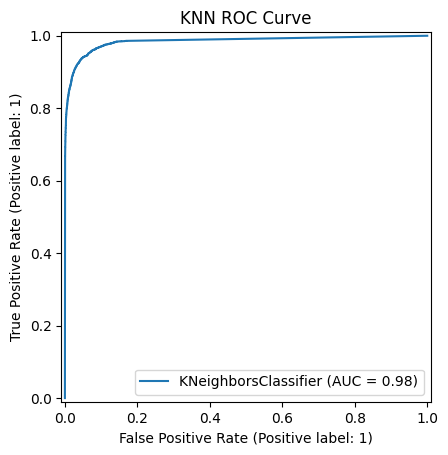

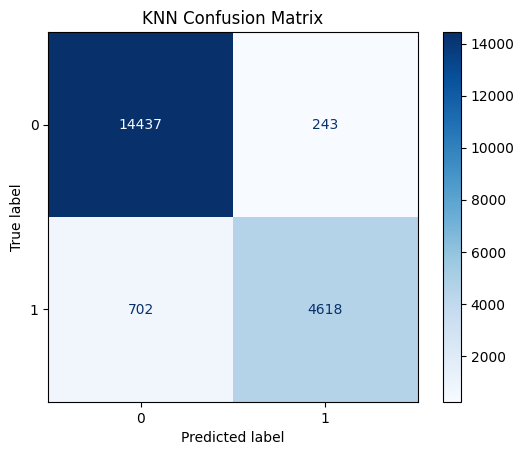

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay

# ROC Curve
RocCurveDisplay.from_estimator(best_knn, X_test, y_test)
plt.title("KNN ROC Curve")
plt.show()

# Confusion Matrix Heatmap
ConfusionMatrixDisplay.from_estimator(best_knn, X_test, y_test, cmap=plt.cm.Blues)
plt.title("KNN Confusion Matrix")
plt.show()

In [42]:
import joblib

# Save the trained KNN model
joblib.dump(best_knn, "knn_fraud_model.pkl")
print("Model saved as knn_fraud_model.pkl")

Model saved as knn_fraud_model.pkl


In [43]:
# Load the saved KNN model
loaded_knn = joblib.load("knn_fraud_model.pkl")

# Use it for prediction
y_new_pred = loaded_knn.predict(X_test)

# test

In [44]:
import pandas as pd
import joblib

# 1. Load the saved KNN model
model = joblib.load("knn_fraud_model.pkl")

# 2. Load new incoming claims data
new_data = pd.read_csv("dataset3.csv")

# 3. Preprocess new data (must match training preprocessing)
#    - Drop the same columns as before
drop_cols = ['Claim_ID', 'Policy_Num', 'Vehicle_Registration',
             'Bind_Date1', 'Policy_Start_Date', 'Policy_Expiry_Date',
             'Accident_Date', 'Claims_Date', 'DL_Expiry_Date']
new_data = new_data.drop(columns=drop_cols)

#    - Handle missing values (use median/mode)
for col in new_data.select_dtypes(include=['float64', 'int64']).columns:
    new_data[col] = new_data[col].fillna(new_data[col].median())

for col in new_data.select_dtypes(include=['object']).columns:
    new_data[col] = new_data[col].fillna(new_data[col].mode()[0])

#    - One-hot encode categorical variables (align with training columns)
new_data = pd.get_dummies(new_data)

#    - Align columns with the training set (add missing columns as 0)
for col in X_train.columns:
    if col not in new_data.columns:
        new_data[col] = 0

#    - Ensure correct column order
new_data = new_data[X_train.columns]

# 4. Predict fraud probability and class
predictions = model.predict(new_data)
pred_prob = model.predict_proba(new_data)[:, 1]

# 5. Save results
new_data['Fraud_Prediction'] = predictions
new_data['Fraud_Probability'] = pred_prob

new_data.to_csv("predicted_claims.csv", index=False)
print("Predictions saved to predicted_claims.csv")


Predictions saved to predicted_claims.csv


In [47]:
# Load the test dataset again
test_data = pd.read_csv("dataset2.csv")

# Keep a copy of true labels for evaluation
# Convert true labels to 0/1 format
y_true = y_true.map({'N': 0, 'Y': 1})

# Drop target column from test data before prediction
test_data_input = test_data.drop(columns=['Fraud_Ind'])

# Use the same pipeline steps we built for new claims
drop_cols = ['Claim_ID', 'Policy_Num', 'Vehicle_Registration',
             'Bind_Date1', 'Policy_Start_Date', 'Policy_Expiry_Date',
             'Accident_Date', 'Claims_Date', 'DL_Expiry_Date']
test_data_input = test_data_input.drop(columns=drop_cols)

for col in test_data_input.select_dtypes(include=['float64', 'int64']).columns:
    test_data_input[col] = test_data_input[col].fillna(test_data_input[col].median())

for col in test_data_input.select_dtypes(include=['object']).columns:
    test_data_input[col] = test_data_input[col].fillna(test_data_input[col].mode()[0])

# One-hot encode
test_data_input = pd.get_dummies(test_data_input)

# Align columns with training data
for col in X_train.columns:
    if col not in test_data_input.columns:
        test_data_input[col] = 0

test_data_input = test_data_input[X_train.columns]

# Load the saved KNN model
from joblib import load
knn_model = load("knn_fraud_model.pkl")

# Predict
y_pred = knn_model.predict(test_data_input)
y_prob = knn_model.predict_proba(test_data_input)[:, 1]

# Evaluate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("ROC-AUC:", roc_auc_score(y_true, y_prob))


Accuracy: 0.94895
Precision: 0.945676964544889
Recall: 0.8573308270676692
F1 Score: 0.8993394459232968
ROC-AUC: 0.9827144240027862


In [48]:
import pandas as pd

# Save feature names used during training
pd.DataFrame(X_train.columns, columns=["columns"]).to_csv("X_train_columns.csv", index=False)